In [1]:
# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS

Using TensorFlow backend.


In [2]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


Sentence_1 = 'Life well spent is life good'
Sentence_2 = 'Life is an art and it is good so far'
Sentence_3 = 'Life well spent is life bad'
    
jaccard(Sentence_1,Sentence_2)
jaccard(Sentence_1,Sentence_3)

0.6666666666666666

## 1) Load Data

In [3]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")
df_submission=pd.read_csv("input/submission.csv")

In [4]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (27486, 4)
Training Set Memory Usage = 0.84 MB
Test Set Shape = (3535, 3)
Test Set Memory Usage = 0.08 MB


In [5]:
df_train.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [6]:
df_test.head()

,textID,text,sentiment
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive
1,fd1db57dc0,i'm done.haha. HOUSE MD marathon ulet,positive
2,2524332d66,I'm concerned for that family,positive
3,0fb19285b2,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have...,positive
4,e6c9e5e3ab,26th February,neutral


## 2) EDA

In [7]:
df_train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [8]:
df_train[df_train["text"].isnull()].head()

,textID,text,selected_text,sentiment
13133,fdb77c3752,NaN,NaN,neutral


In [9]:
df_train= df_train.dropna()

In [10]:
df_train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7786
Name: sentiment, dtype: int64

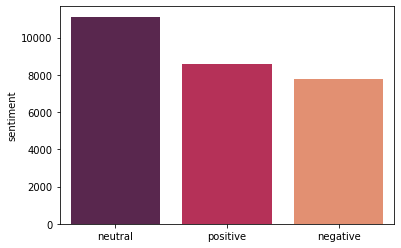

In [11]:
sns.barplot(df_train['sentiment'].value_counts().index,df_train['sentiment'].value_counts(),palette='rocket')

In [12]:
df_test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [13]:
df_test['sentiment'].value_counts()

neutral     1430
positive    1104
negative    1001
Name: sentiment, dtype: int64

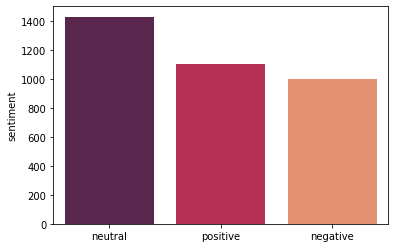

In [14]:
sns.barplot(df_test['sentiment'].value_counts().index,df_test['sentiment'].value_counts(),palette='rocket')

In [15]:
df_train['text_length']=[ len(x) for x in df_train['text']]
df_train['text_word_count']= df_train['text'].apply(lambda x: len(str(x).split()))


df_test['text_length']=[ len(x) for x in df_test['text']]
df_test['text_word_count']= df_test['text'].apply(lambda x: len(str(x).split()))

df_train.head()

,textID,text,selected_text,sentiment,text_length,text_word_count
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,132,28
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,46,9
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,69,9
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,43,9
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,39,6


In [16]:
df_train_positive= df_train[df_train["sentiment"]=="positive"]
df_train_negative= df_train[df_train["sentiment"]=="negative"]
df_train_neutral= df_train[df_train["sentiment"]=="neutral"]

In [17]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    comment_words = ''
    for val in data:
        val = str(val) 
        tokens = val.split() 
      
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
     
        for words in tokens: 
            comment_words = comment_words + words + ' '
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
    return wordcloud
    


In [18]:
wordcloud_positive= show_wordcloud(df_train_positive["selected_text"])
wordcloud_negative= show_wordcloud(df_train_negative["selected_text"])
wordcloud_neutral= show_wordcloud(df_train_neutral["selected_text"])


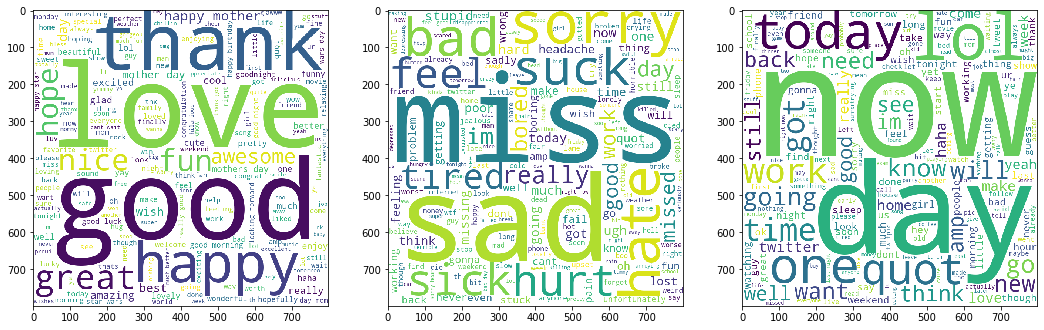

In [19]:
f = plt.figure(figsize = (18, 18))
f.add_subplot(1,3, 1)
plt.imshow(wordcloud_positive)
f.add_subplot(1,3, 2)
plt.imshow(wordcloud_negative)
f.add_subplot(1,3, 3)
plt.imshow(wordcloud_neutral)
plt.show(block=True)

[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'text_length_count'),
 Text(0.5, 1.0, 'text_length for test data')]

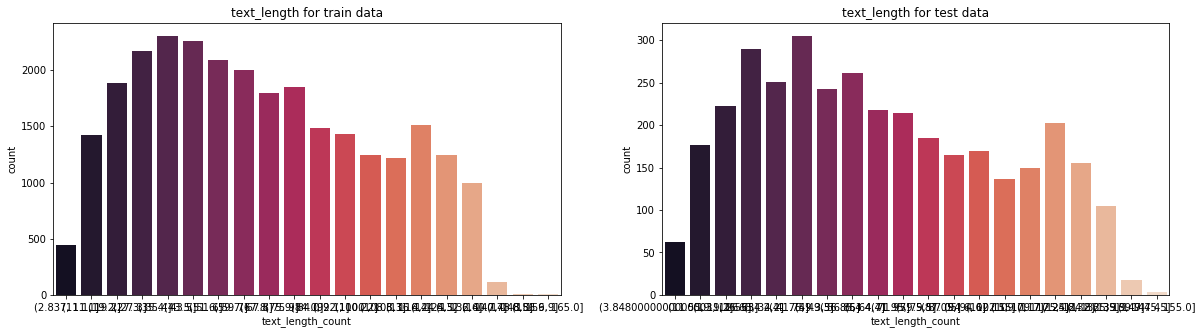

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax_train=sns.barplot(df_train['text_length'].value_counts(bins=20,sort=False).index,
            df_train['text_length'].value_counts(bins=20,sort=False),palette='rocket', ax=ax1)
ax_train.set(xlabel='text_length_count', ylabel='count', title='text_length for train data')


ax_test=sns.barplot(df_test['text_length'].value_counts(bins=20,sort=False).index,
            df_test['text_length'].value_counts(bins=20,sort=False),palette='rocket', ax=ax2)
ax_test.set(xlabel='text_length_count', ylabel='count', title='text_length for test data')

[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'text_word_count'),
 Text(0.5, 1.0, 'word_count for test data')]

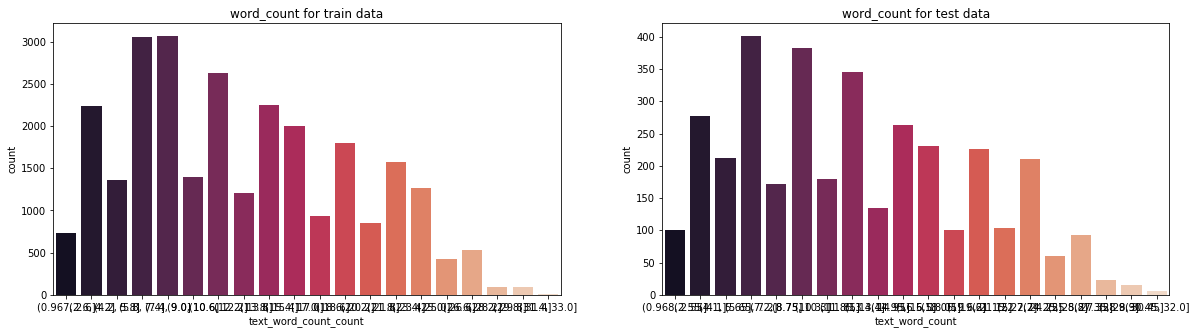

In [21]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax_train=sns.barplot(df_train['text_word_count'].value_counts(bins=20,sort=False).index,
            df_train['text_word_count'].value_counts(bins=20,sort=False),palette='rocket', ax=ax1)
ax_train.set(xlabel='text_word_count_count', ylabel='count', title='word_count for train data')


ax_test=sns.barplot(df_test['text_word_count'].value_counts(bins=20,sort=False).index,
            df_test['text_word_count'].value_counts(bins=20,sort=False),palette='rocket', ax=ax2)
ax_test.set(xlabel='text_word_count', ylabel='count', title='word_count for test data')



## 3) BERT

In [22]:
df_mislabeled = df_train.groupby('textID')['textID'].value_counts()

print(df_train.groupby('textID')['textID'].value_counts())


###NO duplicates

textID      textID    
0003e2a304  0003e2a304    1
0004c81c93  0004c81c93    1
0009df8104  0009df8104    1
000a596b74  000a596b74    1
000c2fc4a9  000c2fc4a9    1
                         ..
ffe6fab196  ffe6fab196    1
fff17f71fe  fff17f71fe    1
fff190b4af  fff190b4af    1
fff44ae9f9  fff44ae9f9    1
fff983ef6b  fff983ef6b    1
Name: textID, Length: 27485, dtype: int64


In [23]:
import transformers as ppb # pytorch transformers

In [24]:
batch_size=32
step= int(df_train['text'].shape[0]/batch_size) +1


In [25]:
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#model = model_class.from_pretrained(pretrained_weights)
model = ppb.BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [28]:
df_test

,textID,text,sentiment,text_length,text_word_count
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive,75,13
1,fd1db57dc0,i'm done.haha. HOUSE MD marathon ulet,positive,37,6
2,2524332d66,I'm concerned for that family,positive,30,5
3,0fb19285b2,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have...,positive,74,15
4,e6c9e5e3ab,26th February,neutral,14,2
...,...,...,...,...,...
3530,2f8444db6c,@_shannon1234 Shannie im so sorry! didnt mean ...,negative,120,23
3531,11de8c0456,Im Slowing on My Tweets..Cuase I Lost My Phone,negative,46,9
3532,08f6036add,"Invasion of the Old Ladies has just ended, sti...",neutral,121,25
3533,27d6472b81,$#@! My nose stud fell out and I can't find it...,negative,115,25


In [29]:
import torch

question, text = df_test['sentiment'][5], df_test['text'][5]
input_ids = tokenizer.encode(question, text)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])

print(answer)

print(input_ids)
print(all_tokens)

tracy and berwick breaks my ac ##hy break ##y heart they split ways in the hallways .
[101, 4997, 102, 10555, 1998, 24957, 7807, 2026, 9353, 10536, 3338, 2100, 2540, 2027, 3975, 3971, 1999, 1996, 28274, 1012, 102]
['[CLS]', 'negative', '[SEP]', 'tracy', 'and', 'berwick', 'breaks', 'my', 'ac', '##hy', 'break', '##y', 'heart', 'they', 'split', 'ways', 'in', 'the', 'hallways', '.', '[SEP]']


In [33]:
df_test['answer']=df_test['text']

In [30]:
df_test.head(10)


,textID,text,sentiment,text_length,text_word_count
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive,75,13
1,fd1db57dc0,i'm done.haha. HOUSE MD marathon ulet,positive,37,6
2,2524332d66,I'm concerned for that family,positive,30,5
3,0fb19285b2,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have...,positive,74,15
4,e6c9e5e3ab,26th February,neutral,14,2
5,311d2b185b,Tracy and Berwick breaks my achy breaky heart ...,negative,79,14
6,95dfefd4e7,Well off 2 bed...cant wait 2 party 4 Mother's ...,positive,72,16
7,739f17cfe1,Oh yeah the camera clipping problems with Void...,positive,98,17
8,c6322a85c2,_Layne hmm.. what's ur fav movie?? tv shows??,neutral,46,8
9,b4401d6b4d,"salt and vinegar, cheese and onion make your ...",negative,69,12


In [34]:
import time

def qa(data, model):
        
    start_time = time.time()
    for i in range(data.shape[0]):
        question = data['sentiment'][i]
        context= data['text'][i]
        input_ids = tokenizer.encode(question, context)
        token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
        start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))

        all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
        answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])
        if not answer:
            data.loc[[i], ['answer'] ] = data['text'][i]
            #data['answer'][i] = data['text'][i]
        else :
            data.loc[[i], ['answer'] ] = answer
        if i%500 ==0:
            print(i)
        
    end_time = time.time()
    print(end_time-start_time)

In [35]:
qa(df_test, model)

0
500
1000
1500
2000
2500
3000
3500
501.1716265678406


In [ ]:
df_test.head(-50)

In [ ]:
df_submission['selected_text']= df_test['answer']

In [ ]:
df_submission.head()

In [ ]:
import time
import csv

# df_submission.to_csv('submission_{}.csv'.format(time.time()), index=False, )
# df_submission.head()

## 4) DistillBERT + SQuAD

In [ ]:
%%time


import json
use_cuda = True

"""
Prepare training data in QA-compatible format
"""

# Adpated from https://www.kaggle.com/cheongwoongkang/roberta-baseline-starter-simple-postprocessing
def find_all(input_str, search_str):
    l1 = []
    length = len(input_str)
    index = 0
    while index < length:
        i = input_str.find(search_str, index)
        if i == -1:
            return l1
        l1.append(i)
        index = i + 1
    return l1

def do_qa_train(train):

    output = {}
    output['version'] = 'v1.0'
    output['data'] = []
    paragraphs = []
    for line in train:
        context = line[1]

        qas = []
        question = line[-1]
        qid = line[0]
        answers = []
        answer = line[2]
        if type(answer) != str or type(context) != str or type(question) != str:
            print(context, type(context))
            print(answer, type(answer))
            print(question, type(question))
            continue
        answer_starts = find_all(context, answer)
        for answer_start in answer_starts:
            answers.append({'answer_start': answer_start, 'text': answer.lower()})
            break
        qas.append({'question': question, 'id': qid, 'is_impossible': False, 'answers': answers})

        paragraphs.append({'context': context.lower(), 'qas': qas})
        output['data'].append({'title': 'None', 'paragraphs': paragraphs})
        
    return paragraphs




In [ ]:
%%time

"""
Prepare testing data in QA-compatible format
"""

output = {}
output['version'] = 'v1.0'
output['data'] = []

def do_qa_test(test):
    paragraphs = []
    for line in test:
        context = line[1]
        qas = []
        question = line[-1]
        qid = line[0]
        if type(context) != str or type(question) != str:
            print(context, type(context))
            print(answer, type(answer))
            print(question, type(question))
            continue
        answers = []
        answers.append({'answer_start': 1000000, 'text': '__None__'})
        qas.append({'question': question, 'id': qid, 'is_impossible': False, 'answers': answers})

        paragraphs.append({'context': context.lower(), 'qas': qas})
        output['data'].append({'title': 'None', 'paragraphs': paragraphs})
    return paragraphs





In [ ]:
from sklearn.model_selection import train_test_split



df_train_distillbert = pd.read_csv("input/train.csv")
df_test_distillbert = pd.read_csv("input/test.csv")
df_submission_distillbert=pd.read_csv("input/submission.csv")

y=df_train_distillbert.selected_text
df_train_distillbert.drop(columns=['selected_text'], inplace= True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(df_train_distillbert, y,train_size=0.8, test_size=0.2,random_state=1)

# print(df_train_distillbert.shape)
# print(X_train)
# print(X_valid)
# print(y_train)
# print(y_valid)


train=pd.concat([X_train, y_train], axis=1)
valid=pd.concat([X_valid, y_valid], axis=1)
print(train)
train_df=train.reindex(columns=['textID','text','selected_text','sentiment']).reset_index(drop=True)
valid_df=valid.reindex(columns=['textID','text','selected_text','sentiment']).reset_index(drop=True)
print(train_df)

train = np.array(train_df)
valid = np.array(valid_df)
test = np.array(df_test_distillbert)

qa_train = do_qa_train(train)
qa_valid = do_qa_train(valid)
qa_test = do_qa_test(test)

with open('input/test.json', 'w') as outfile:
    json.dump(qa_test, outfile)

with open('input/valid.json', 'w') as outfile:
    json.dump(qa_valid, outfile)    
    
with open('input/train.json', 'w') as outfile:
    json.dump(qa_train, outfile)

In [ ]:
%%time

from simpletransformers.question_answering import QuestionAnsweringModel

#Path for Kaggle
MODEL_PATH = '/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/'

#Path in general
MODEL_PATH = 'distilbert-base-uncased-distilled-squad'

NUMBER_MODELS=8
# Create QuestionAnsweringModel with different parameters:

# model_1: base one
# model_2: weight_decay .1 +  gradient_accumulation_steps 2
# model_3: learning rate 2e-5 + weight_decay .1 +  gradient_accumulation_steps 2
# model_4: weight_decay .01 +  gradient_accumulation_steps 3
# model_5: learning rate 3e-5 + weight_decay .1
# model_6: gradient_accumulation_steps 8 + + weight_decay .1
# model_7: weight_decay .2 
# model_8: weight_decay .005



# model_1 = QuestionAnsweringModel('distilbert', 
#                                MODEL_PATH, 
#                                args={'output_dir': "outputs_{}/".format(1),
#                                      'reprocess_input_data': True,
#                                      'overwrite_output_dir': True,
#                                      'learning_rate': 5e-5,
#                                      'num_train_epochs': 2,
#                                      'max_seq_length': 128,
#                                      'doc_stride': 64,
#                                      'fp16': False,
#                                     },
#                               use_cuda=use_cuda)

# model_2 = QuestionAnsweringModel('distilbert', 
#                                MODEL_PATH, 
#                                args={'output_dir': "outputs_{}/".format(2),
#                                    'reprocess_input_data': True,
#                                      'overwrite_output_dir': True,
#                                      'learning_rate': 5e-5,
#                                      'num_train_epochs': 2,
#                                      'max_seq_length': 128,
#                                      'doc_stride': 64,
#                                      'fp16': False,
#                                      'gradient_accumulation_steps': 2,
#                                      'weight_decay': 0.1
#                                     },
#                               use_cuda=use_cuda)

# model_3 = QuestionAnsweringModel('distilbert', 
#                                MODEL_PATH, 
#                                args={'output_dir': "outputs_{}/".format(3),
#                                    'reprocess_input_data': True,
#                                      'overwrite_output_dir': True,
#                                      'learning_rate': 2e-5,
#                                      'num_train_epochs': 2,
#                                      'max_seq_length': 128,
#                                      'doc_stride': 64,
#                                      'fp16': False,
#                                      'gradient_accumulation_steps': 2,
#                                      'weight_decay': 0.1
#                                     },
#                               use_cuda=use_cuda)

# model_4 = QuestionAnsweringModel('distilbert', 
#                                MODEL_PATH, 
#                                args={'output_dir': "outputs_{}/".format(4),
#                                      'reprocess_input_data': True,
#                                      'overwrite_output_dir': True,
#                                      'learning_rate': 5e-5,
#                                      'num_train_epochs': 2,
#                                      'max_seq_length': 128,
#                                      'doc_stride': 64,
#                                      'fp16': False,
#                                      'gradient_accumulation_steps': 3,
#                                      'weight_decay': 0.01
#                                     },
#                               use_cuda=use_cuda)

# model_5 = QuestionAnsweringModel('distilbert', 
#                                MODEL_PATH, 
#                                args={'output_dir': "outputs_{}/".format(5),
#                                      'reprocess_input_data': True,
#                                      'overwrite_output_dir': True,
#                                      'learning_rate': 3e-5,
#                                      'num_train_epochs': 2,
#                                      'max_seq_length': 128,
#                                      'doc_stride': 64,
#                                      'fp16': False,
#                                      'weight_decay': 0.01
#                                     },
#                               use_cuda=use_cuda)

# model_6 = QuestionAnsweringModel('distilbert', 
#                                MODEL_PATH, 
#                                args={'output_dir': "outputs_{}/".format(6),
#                                      'reprocess_input_data': True,
#                                      'overwrite_output_dir': True,
#                                      'learning_rate': 5e-5,
#                                      'num_train_epochs': 2,
#                                      'max_seq_length': 128,
#                                      'doc_stride': 64,
#                                      'fp16': False,
#                                      'gradient_accumulation_steps': 8,
#                                      'weight_decay': 0.01
#                                     },
#                               use_cuda=use_cuda)

# model_7 = QuestionAnsweringModel('distilbert', 
#                                MODEL_PATH, 
#                                args={'output_dir': "outputs_{}/".format(7),
#                                    'reprocess_input_data': True,
#                                      'overwrite_output_dir': True,
#                                      'learning_rate': 5e-5,
#                                      'num_train_epochs': 2,
#                                      'max_seq_length': 128,
#                                      'doc_stride': 64,
#                                      'fp16': False,
#                                      'weight_decay': 0.2
#                                     },
#                               use_cuda=use_cuda)


# model_8 = QuestionAnsweringModel('distilbert', 
#                                MODEL_PATH, 
#                                args={'output_dir': "outputs_{}/".format(8),
#                                    'reprocess_input_data': True,
#                                      'overwrite_output_dir': True,
#                                      'learning_rate': 5e-5,
#                                      'num_train_epochs': 2,
#                                      'max_seq_length': 128,
#                                      'doc_stride': 64,
#                                      'fp16': False,
#                                      'weight_decay': 0.005
#                                     },
#                               use_cuda=use_cuda)


In [ ]:
# %%time

# model_1.train_model('input/train.json')
# print('model 1 finished')
# model_2.train_model('input/train.json')
# print('model 2 finished')
# model_3.train_model('input/train.json')
# print('model 3 finished')
# model_4.train_model('input/train.json')
# print('model 4 finished')
# model_5.train_model('input/train.json')
# print('model 5 finished')
# model_6.train_model('input/train.json')
# print('model 6 finished')
# model_7.train_model('input/train.json')
# print('model 7 finished')
# model_8.train_model('input/train.json')
# print('model 8 finished')

In [ ]:
#evaluate the different models on validation data
predictions_1 = model_1.predict(qa_valid)
predictions_2 = model_2.predict(qa_valid)
predictions_3 = model_3.predict(qa_valid)
predictions_4 = model_4.predict(qa_valid)
predictions_5 = model_5.predict(qa_valid)
predictions_6 = model_6.predict(qa_valid)
predictions_7 = model_7.predict(qa_valid)
predictions_8 = model_8.predict(qa_valid)

predictions_1_df = pd.DataFrame.from_dict(predictions_1)
predictions_2_df = pd.DataFrame.from_dict(predictions_2)
predictions_3_df = pd.DataFrame.from_dict(predictions_3)
predictions_4_df = pd.DataFrame.from_dict(predictions_4)
predictions_5_df = pd.DataFrame.from_dict(predictions_5)
predictions_6_df = pd.DataFrame.from_dict(predictions_6)
predictions_7_df = pd.DataFrame.from_dict(predictions_7)
predictions_8_df = pd.DataFrame.from_dict(predictions_8)

valid_df['selected_text_predict_1'] = predictions_1_df['answer']
valid_df['selected_text_predict_2'] = predictions_2_df['answer']
valid_df['selected_text_predict_3'] = predictions_3_df['answer']
valid_df['selected_text_predict_4'] = predictions_4_df['answer']
valid_df['selected_text_predict_5'] = predictions_5_df['answer']
valid_df['selected_text_predict_6'] = predictions_6_df['answer']
valid_df['selected_text_predict_7'] = predictions_7_df['answer']
valid_df['selected_text_predict_8'] = predictions_8_df['answer']




In [ ]:
valid_df.head(50)

In [ ]:
for i in range(1,NUMBER_MODELS+1):
    valid_df['jaccard_' + str(i)] = ""

def compute_jaccard(number_models, valid_df):
    n_row=valid_df.shape[0]
    for i in range(n_row):
        for j in range(1,number_models+1):
            column='selected_text_predict_' + str(j)
            valid_df['jaccard_'+str(j)][i] = jaccard(valid_df['selected_text'][i],valid_df[column][i])

    pass
            
            
        
compute_jaccard(NUMBER_MODELS,valid_df)




In [ ]:
valid_df

In [ ]:
res=dict()
for i in range(1,NUMBER_MODELS+1):          
    res['model_'+str(i)] = valid_df['jaccard_'+str(i)].mean()

sorted_res = sorted(res.items(), key=lambda kv: kv[1], reverse= True)
print(sorted_res)

In [ ]:
# %%time

# predictions = model_1.predict(qa_test)
# predictions_df = pd.DataFrame.from_dict(predictions)

# df_submission_distillbert['selected_text'] = predictions_df['answer']

# df_submission_distillbert.to_csv('submission_{}.csv'.format(time.time()), index=False)
# print("File submitted successfully.")

## 6) Others

In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

In [ ]:
tokenized = df_train['text'][:step].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
input_ids = torch.tensor(padded).to(torch.int64) 
attention_mask = torch.tensor(attention_mask)


In [ ]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
last_hidden_states